# FRE-GY 9713 Final Project

# Lin Hui, Chris Abruzzo & Vatanak Lim

Contributions

Vatanak Lim: Data Structures, Action Preference Function, Computed Gradient, Comments

Chris Abruzzo: Implemented Problem 1, 3 $\alpha$-reducing schemes

Lin Hui: Implemented Problem 2, Both Linear and Quadratic Baseline Functions

In [31]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(18)

In [32]:
# df_train = pd.read_csv("/Users/vatanaklim/Desktop/RL Final/train_data", sep="|")
# df_test = pd.read_csv("/Users/vatanaklim/Desktop/RL Final/test_data", sep="|")
df_train = pd.read_csv("C:/Users/abruz/Documents/NYU/Active Portfolio Management/train_data", sep="|")
df_test = pd.read_csv("C:/Users/abruz/Documents/NYU/Active Portfolio Management/test_data", sep="|")

In [33]:
state_train = df_train.copy()
C_train = df_train.copy()
state_test = df_test.copy()
C_test = df_test.copy()

In [34]:
state_train.drop(['C'], axis=1, inplace=True)
C_train.drop(['episode', 't', 'S'], axis=1, inplace=True)
state_test.drop(['C'], axis=1, inplace=True)
C_test.drop(['episode', 't', 'S'], axis=1, inplace=True)

In [35]:
state_train['t'] = 30 - state_train['t']
state_test['t'] = 30 - state_test['t']

In [36]:
state_train.rename(columns={"t": "tao"}, inplace=True)
state_test.rename(columns={"t": "tao"}, inplace=True)
state_train['n'] = 0
state_test['n'] = 0

In [37]:
state_train.head()

,episode,tao,S,n
0,1,29,10.000000,0
1,1,28,9.638533,0
2,1,27,9.491188,0
3,1,26,9.259321,0
4,1,25,9.243345,0


In [38]:
state_train.tail()

,episode,tao,S,n
29999995,1000000,4,11.898653,0
29999996,1000000,3,11.818816,0
29999997,1000000,2,11.798725,0
29999998,1000000,1,12.160278,0
29999999,1000000,0,12.061033,0


In [39]:
state_test.head()

,episode,tao,S,n
0,1,29,10.000000,0
1,1,28,9.921081,0
2,1,27,9.810410,0
3,1,26,10.198508,0
4,1,25,10.386982,0


In [40]:
state_test.tail()

,episode,tao,S,n
29995,1000,4,8.009915,0
29996,1000,3,7.818832,0
29997,1000,2,7.807271,0
29998,1000,1,7.663955,0
29999,1000,0,7.397956,0


In [41]:
C_train.head()

,C
0,0.082495
1,0.046049
2,0.033490
3,0.020358
4,0.017606


In [42]:
C_test.head()

,C
0,0.082495
1,0.069225
2,0.054784
3,0.087494
4,0.104631


# $h(s, a, \theta) = \frac{1}{\sqrt{2\pi}}e^\frac{-(a+100N(d_{1}))^2}{2}$

# $h(s, a, \theta)$ peaks when $a = -100N(d_{1})$

# $d_1 = \frac{ln(\frac{S_t}{K})+\frac{\theta^2\tau}{2}}{\theta \sqrt{\tau}}$

In [43]:
def h_func(s, a, theta):
    
    d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))

    # s[1] is St and s[0] is tao. and s[2] is action

    Nd1 = norm.cdf(d1)

    return np.exp((-abs(s[2] + 100 * Nd1) * 0.5)) / (np.sqrt(2 * np.pi))

# $\pi(a|s,\theta) = \frac{e^{h(s,a,\theta)}}{\sum \limits _{a'}e^{h(s,a',\theta)}}$

In [44]:
def pi(s, theta):
    
    results = np.empty(101)
    temp = np.empty(101)
    summation = 0
    
    for i in range(101):
        
        temp_i = np.exp(h_func(s, i, theta))
        temp[i] = temp_i
        
        if pd.isna(temp_i) or math.isinf(temp_i):
            summation += 0
            
        else:
            summation += temp[i]
        
    for a in range(101):
        
        temp_a = temp[a]
        
        if pd.isna(temp_a) or math.isinf(temp_a):
            results[a] = 0
            
        else:
            results[a] = temp_a / summation

    return results

# $\triangledown ln\pi (a_t|s_t,\theta) = \triangledown h(s,a,\theta) - \sum \limits _{a'}\pi (a'|s, \theta)\triangledown h(s,a',\theta)$

# $\triangledown h(s,a,\theta) = -\frac{100}{2\pi}(a+100N(d_1))e^{\frac{-(a+100N(d_{1}))^2-d_1^2}{2}}d_1' $

# $d_1' = \frac{\theta^2\tau - (ln(\frac{S_t}{K})+\frac{\theta^2\tau}{2})}{\theta^2\sqrt{\tau}}$

In [45]:
def gradient_a(s, a, theta):
    
    d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
    Nd1 = norm.cdf(d1)
    d1_prime = (theta[a] * theta[a] * s[0] - (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5))) / (
            theta[a] * theta[a] * np.sqrt(s[0]))

    return -100 * (a + 100 * Nd1) * np.exp(-((a + 100 * Nd1) * (a + 100 * Nd1) - d1 * d1) * 0.5) * d1_prime / (2 * np.pi)

In [46]:
def gradient(s, theta):
    
    results = np.zeros(101)

    for i in range(101):
        
        results[i] = gradient_a(s, i, theta)

    return results

# We tried 3 $\alpha$-reducing schemes, time based decay, step decay and exponential decay.

In [47]:
def time_based_decay(episodes, alpha):
    k_ = 0.001
    return alpha/(1 + k_*episodes)

In [48]:
def step_decay(episodes, alpha):
    drop = 0.5
    episodes_drop = 10.0
    new_alpha = alpha * math.pow(drop, math.floor((1+episodes)/episodes_drop))
    return new_alpha

In [49]:
def exponential_decay(episodes, alpha):
    k_ = 0.001
    return alpha*np.exp(-k_*episodes)

In [50]:
state_train = state_train.to_numpy()
C_train = C_train.to_numpy()
state_test = state_test.to_numpy()
C_test = C_test.to_numpy()

# Problem 1 -  Without Baseline

# Training with 1,000 episodes

In [51]:
NUM_EPISODES = 1000
ACTION_SIZE = 101
alpha = 0.10
K = 12.5
T = 30
theta = np.random.rand(ACTION_SIZE)
Episode_G = np.zeros(NUM_EPISODES)
#First without Baseline

# $P_t = 100*(C_t - C_{t-1}) + n_{t-1}*(S_t - S_{t-1}) $

In [52]:
for e in range(NUM_EPISODES):
    
    print('Training Episode', e)
    
    s = state_train[e * T: e * T + T, 1:]
    actions = np.zeros(T)
    rewards = np.zeros(T)
    
    for t in range(T):
        prob = pi(s[t], theta)
        action = - np.random.choice(ACTION_SIZE, p=prob)
        actions[t] = action
        
        if t == 0:
            rewards[0] = 0
        else:
            Pt = 100 * (C_train[e * T + t] - C_train[e * T + t - 1]) + (s[t, 1] - state_train[e * T + t - 1][2]) * actions[
                t - 1]
            rewards[t] = -Pt * Pt / T

    state_train[e * T: e * T + T, 3] = actions

    for t in range(T):
        G = rewards[t + 1:].sum()
        if t == T - 1:
            break
        s = state_train[e * T: e * T + T, 1:]
        state_tao = s[t]
        grad = gradient(state_tao, theta)

        theta = np.array(theta + alpha * G * grad)
        
        np.nan_to_num(theta, copy=False, nan=0.0)

    Episode_G[e] = rewards.sum()
    
    #alpha = time_based_decay(e, alpha)
    alpha = step_decay(e, alpha)
    #alpha = exponential_decay(e, alpha)

Training Episode 0


<ipython-input-43-61a35e10fdd1>:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:8: RuntimeWarning: overflow encountered in exp
  return -100 * (a + 100 * Nd1) * np.exp(-((a + 100 * Nd1) * (a + 100 * Nd1) - d1 * d1) * 0.5) * d1_prime / (2 * np.pi)


Training Episode 1
Training Episode 2


<ipython-input-45-395a728b5f79>:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:5: RuntimeWarning: overflow encountered in double_scalars
  d1_prime = (theta[a] * theta[a] * s[0] - (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5))) / (
<ipython-input-45-395a728b5f79>:5: RuntimeWarning: invalid value encountered in double_scalars
  d1_prime = (theta[a] * theta[a] * s[0] - (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5))) / (
<ipython-input-45-395a728b5f79>:6: RuntimeWarning: overflow encountered in double_scalars
  theta[a] * theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:5: RuntimeWarning: divide by zero encountered in double_scalars
  d1_prime = 

Training Episode 3
Training Episode 4
Training Episode 5
Training Episode 6
Training Episode 7
Training Episode 8
Training Episode 9
Training Episode 10
Training Episode 11
Training Episode 12
Training Episode 13
Training Episode 14
Training Episode 15
Training Episode 16
Training Episode 17
Training Episode 18
Training Episode 19
Training Episode 20
Training Episode 21
Training Episode 22
Training Episode 23
Training Episode 24
Training Episode 25
Training Episode 26
Training Episode 27
Training Episode 28
Training Episode 29
Training Episode 30
Training Episode 31
Training Episode 32
Training Episode 33
Training Episode 34
Training Episode 35
Training Episode 36
Training Episode 37
Training Episode 38
Training Episode 39
Training Episode 40
Training Episode 41
Training Episode 42
Training Episode 43
Training Episode 44
Training Episode 45
Training Episode 46
Training Episode 47
Training Episode 48
Training Episode 49
Training Episode 50
Training Episode 51
Training Episode 52
Trainin

<ipython-input-52-c1cc2f6c55c2>:31: RuntimeWarning: invalid value encountered in multiply
  theta = np.array(theta + alpha * G * grad)


 152
Training Episode 153
Training Episode 154
Training Episode 155
Training Episode 156
Training Episode 157
Training Episode 158
Training Episode 159
Training Episode 160
Training Episode 161
Training Episode 162
Training Episode 163
Training Episode 164
Training Episode 165
Training Episode 166
Training Episode 167
Training Episode 168
Training Episode 169
Training Episode 170
Training Episode 171
Training Episode 172
Training Episode 173
Training Episode 174
Training Episode 175
Training Episode 176
Training Episode 177
Training Episode 178
Training Episode 179
Training Episode 180
Training Episode 181
Training Episode 182
Training Episode 183
Training Episode 184
Training Episode 185
Training Episode 186
Training Episode 187
Training Episode 188
Training Episode 189
Training Episode 190
Training Episode 191
Training Episode 192
Training Episode 193
Training Episode 194
Training Episode 195
Training Episode 196
Training Episode 197
Training Episode 198
Training Episode 199
Training

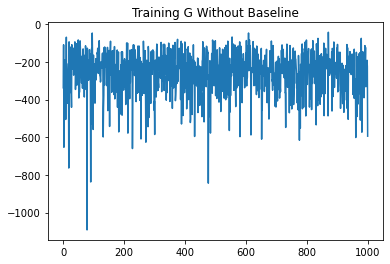

In [53]:
plt.plot(np.arange(NUM_EPISODES), Episode_G)
plt.title("Training G Without Baseline")
plt.show()

# $\theta$ that final policy is using.

In [54]:
print(theta)

[0.65037424 0.50545337 0.87860147 0.46456609 0.85223307 0.75013629
 0.66610167 0.98789545 0.25696842 0.         0.63571912 0.84731239
 0.73617463 0.90900139 0.11160313 0.29772374 0.68697019 0.86162606
 0.19863436 0.65718903 0.69965563 0.35239247 0.78996055 0.81404794
 0.19742128 0.94945529 0.47660039 0.66660035 0.21131204 0.80752632
 0.31968612 0.29393597 0.30191818 0.8278894  0.55253369 0.1916774
 0.71425674 0.63987036 0.53320383 0.57252791 0.         0.69523798
 0.53465921 0.07913472 0.         0.27785304 0.99738528 0.22560064
 0.10501535 0.01630078 0.34162745 0.80819806 0.21731962 0.93460497
 0.98849788 0.         0.78490275 0.68536362 0.51564399 0.26911317
 0.66478147 0.77712445 0.47566571 0.98778624 0.49624539 0.67152209
 0.43025928 0.26097774 0.94419636 0.6871313  0.6596554  0.03536889
 0.90619876 0.41874532 0.4759435  0.13563372 0.36224286 0.32616368
 0.14801784 0.7958857  0.52324211 0.89417431 0.79441573 0.62935313
 0.06712699 0.78727001 0.37892603 0.47062239 0.07910067 0.15341

# Testing with 200 episodes

In [55]:
TEST_EPISODES = 200
test_G = np.zeros(TEST_EPISODES)

for e in range(TEST_EPISODES):
    
    print('Testing Episode', e)
    s = state_test[e * T: e * T + T, 1:]
    actions = np.zeros(T)
    rewards = np.zeros(T)

    for t in range(T):
        prob = pi(s[t], theta)
        action = - np.random.choice(ACTION_SIZE, p=prob)
        actions[t] = action
        
        if t == 0:
            rewards[0] = 0
        else:
            Pt = 100 * (C_test[e * T + t] - C_test[e * T + t - 1]) + (s[t, 1] - state_test[e * T + t - 1][2]) * actions[
                t - 1]
            rewards[t] = -Pt * Pt / T

    state_test[e * T: e * T + T, 3] = actions
    G = rewards.sum()
    test_G[e] = G

Testing Episode 0


<ipython-input-43-61a35e10fdd1>:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))


Testing Episode 1
Testing Episode 2
Testing Episode 3
Testing Episode 4
Testing Episode 5
Testing Episode 6
Testing Episode 7
Testing Episode 8
Testing Episode 9
Testing Episode 10
Testing Episode 11
Testing Episode 12
Testing Episode 13
Testing Episode 14
Testing Episode 15
Testing Episode 16
Testing Episode 17
Testing Episode 18
Testing Episode 19
Testing Episode 20
Testing Episode 21
Testing Episode 22
Testing Episode 23
Testing Episode 24
Testing Episode 25
Testing Episode 26
Testing Episode 27
Testing Episode 28
Testing Episode 29
Testing Episode 30
Testing Episode 31
Testing Episode 32
Testing Episode 33
Testing Episode 34
Testing Episode 35
Testing Episode 36
Testing Episode 37
Testing Episode 38
Testing Episode 39
Testing Episode 40
Testing Episode 41
Testing Episode 42
Testing Episode 43
Testing Episode 44
Testing Episode 45
Testing Episode 46
Testing Episode 47
Testing Episode 48
Testing Episode 49
Testing Episode 50
Testing Episode 51
Testing Episode 52
Testing Episode 53
Te

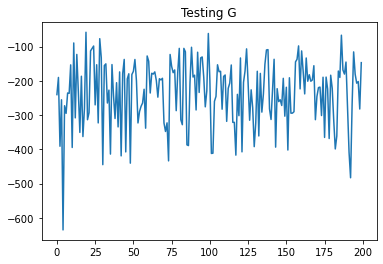

In [56]:
plt.plot(np.arange(TEST_EPISODES), test_G)
plt.title('Testing G')
plt.show()

# Prblem 2 - With Baselines

In [57]:
NUM_EPISODES = 1000
ACTION_SIZE = 101
alpha = 0.10
alpha_w = 0.00025
#For Quadratic Baseline Function, we can online use a much smaller alpha_w
#alpha_w = 0.000000025
K = 12.5
T = 30
theta_b = np.random.rand(ACTION_SIZE)
Episode_G = np.zeros(NUM_EPISODES)
w = np.random.rand(4)
#With Linear Baseline Function

#w = np.random.rand(10)
#With Quadratic Baseline Function

# We tried 2 baseline functions, lineaer and quadratic.

# Linear 
$\hat{v}((S,\tau ,n), \omega) = \omega_0 + \omega_1S + \omega_2\tau + \omega_3n$

# Quadratic 
$\hat{v}((S,\tau ,n), \omega) = \omega_0 + \omega_1S + \omega_2\tau + \omega_3n + \omega_4S\tau + \omega_5Sn + \omega_6\tau n + \omega_7S^2 + \omega_8\tau^2 + \omega_9n^2$

# Training with 1,000 episodes

In [58]:
for e in range(NUM_EPISODES):
    
    print('Training Episode', e)
    s = state_train[e * T: e * T + T, 1:]
    actions = np.zeros(T)
    rewards = np.zeros(T)
    
    for t in range(T):
        prob = pi(s[t], theta_b)
        action = - np.random.choice(ACTION_SIZE, p=prob)
        actions[t] = action
        
        if t == 0:
            rewards[0] = 0
        else:
            Pt = 100 * (C_train[e * T + t] - C_train[e * T + t - 1]) + (s[t, 1] - state_train[e * T + t - 1][2]) * actions[
                t - 1]
            rewards[t] = -Pt * Pt / T

    state_train[e * T: e * T + T, 3] = actions

    for t in range(T):
        G = rewards[t + 1:].sum()
        
        if t == T - 1:
            break
        s = state_train[e * T: e * T + T, 1:]
        state_tao = s[t]
        grad = gradient(state_tao, theta_b)
        
        #For Linear Baseline Function
        delta = G - (w[0] + w[1] * state_tao[1] + w[2] * state_tao[0] + w[3] * state_tao[2])
        grad_v = np.array([1, state_tao[1], state_tao[0], state_tao[2]])
        w = w + alpha_w * delta * grad_v
        theta_b = np.array(theta_b + alpha * delta * G * grad)
        
#         #For Quadratic Baseline Function
#         delta = G - (w[0] + w[1] * state_tao[1] + w[2] * state_tao[0] + w[3] * state_tao[2] + w[4]*state_tao[1]*state_tao[0] + w[5]*state_tao[0]*state_tao[2] + w[6]*state_tao[1]*state_tao[2] + w[7]*state_tao[1]*state_tao[1] +w[8]*state_tao[0]*state_tao[0] + w[9]*state_tao[2]*state_tao[2] )
#         grad_v = np.array([1, state_tao[1], state_tao[0], state_tao[2], state_tao[1]*state_tao[0], state_tao[0]*state_tao[2], state_tao[1]*state_tao[2], state_tao[1]*state_tao[1], state_tao[0]*state_tao[0], state_tao[2]*state_tao[2]])
#         w = w + alpha_w * delta * grad_v
#         theta = np.array(theta + alpha * delta * G * grad)
        
        np.nan_to_num(theta_b, copy=False, nan=0.0)

    Episode_G[e] = rewards.sum()
    
    #alpha = time_based_decay(e, alpha)
    alpha = step_decay(e, alpha)
    #alpha = exponential_decay(e, alpha)

Training Episode 0


<ipython-input-43-61a35e10fdd1>:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:8: RuntimeWarning: overflow encountered in exp
  return -100 * (a + 100 * Nd1) * np.exp(-((a + 100 * Nd1) * (a + 100 * Nd1) - d1 * d1) * 0.5) * d1_prime / (2 * np.pi)
<ipython-input-45-395a728b5f79>:3: RuntimeWarning: overflow encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:3: RuntimeWarning: invalid value encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))
<ipython-input-45-395a728b5f79>:5: RuntimeWarning: overflow encountered in double_scalars
  d1_prime = (theta[a] * theta[a] * s[0] - (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5))) / (
<ipython-input-45-395a728b5f79>:5: RuntimeWarning:

Training Episode 1
Training Episode 2
Training Episode 3
Training Episode 4
Training Episode 5
Training Episode 6
Training Episode 7
Training Episode 8
Training Episode 9
Training Episode 10
Training Episode 11
Training Episode 12
Training Episode 13
Training Episode 14
Training Episode 15
Training Episode 16
Training Episode 17
Training Episode 18
Training Episode 19
Training Episode 20
Training Episode 21
Training Episode 22
Training Episode 23
Training Episode 24
Training Episode 25
Training Episode 26
Training Episode 27
Training Episode 28
Training Episode 29
Training Episode 30
Training Episode 31
Training Episode 32
Training Episode 33
Training Episode 34
Training Episode 35
Training Episode 36
Training Episode 37
Training Episode 38
Training Episode 39
Training Episode 40
Training Episode 41
Training Episode 42
Training Episode 43
Training Episode 44
Training Episode 45
Training Episode 46
Training Episode 47
Training Episode 48
Training Episode 49
Training Episode 50
Training 

<ipython-input-58-5582f9251379>:35: RuntimeWarning: invalid value encountered in multiply
  theta_b = np.array(theta_b + alpha * delta * G * grad)


Training Episode 153
Training Episode 154
Training Episode 155
Training Episode 156
Training Episode 157
Training Episode 158
Training Episode 159
Training Episode 160
Training Episode 161
Training Episode 162
Training Episode 163
Training Episode 164
Training Episode 165
Training Episode 166
Training Episode 167
Training Episode 168
Training Episode 169
Training Episode 170
Training Episode 171
Training Episode 172
Training Episode 173
Training Episode 174
Training Episode 175
Training Episode 176
Training Episode 177
Training Episode 178
Training Episode 179
Training Episode 180
Training Episode 181
Training Episode 182
Training Episode 183
Training Episode 184
Training Episode 185
Training Episode 186
Training Episode 187
Training Episode 188
Training Episode 189
Training Episode 190
Training Episode 191
Training Episode 192
Training Episode 193
Training Episode 194
Training Episode 195
Training Episode 196
Training Episode 197
Training Episode 198
Training Episode 199
Training Epis

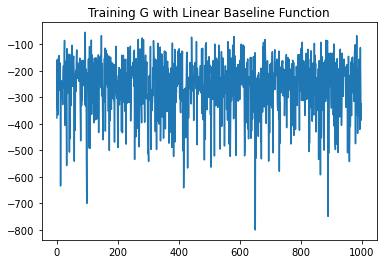

In [59]:
plt.plot(np.arange(NUM_EPISODES), Episode_G)
plt.title("Training G with Linear Baseline Function")
#plt.title("Training G with Quadratic Baseline Function")
plt.show()

# $\theta$ that final policy is using.

In [60]:
print(theta_b)

[0.76073008 0.3544137  0.         0.63243757 0.53108876 0.36870149
 0.71816834 0.98111621 0.22269623 0.57094778 0.18788158 0.68272896
 0.59530391 0.52078497 0.65834521 0.77780006 0.41240159 0.74523986
 0.98531015 0.64052451 0.88787925 0.04752575 0.81718714 0.91703221
 0.29810343 0.81068206 0.61878778 0.74248329 0.29105879 0.86001697
 0.82816899 0.71786551 0.80065374 0.33535087 0.41741893 0.72835863
 0.29411516 0.         0.02587387 0.48898435 0.27297903 0.32189805
 0.32919681 0.39325733 0.83250256 0.94650977 0.5613719  0.3938782
 0.46962238 0.34845153 0.04938655 0.1531686  0.41476421 0.35289572
 0.89444428 0.23639197 0.91559783 0.53808213 0.84179715 0.12285653
 0.32926486 0.22495632 0.5077063  0.04101592 0.38387749 0.74786353
 0.13180598 0.22463586 0.57779227 0.03833115 0.99374232 0.81221726
 0.48607028 0.14551858 0.05468197 0.92782107 0.85584992 0.14500661
 0.01819633 0.7786465  0.66741001 0.93727094 0.21946751 0.41081843
 0.21421234 0.98650074 0.80165111 0.13085842 0.87042615 0.53474

# Testing with 200 episodes

In [61]:
TEST_EPISODES = 200
test_G = np.zeros(TEST_EPISODES)

for e in range(TEST_EPISODES):
    
    print('Testing Episode', e)
    s = state_test[e * T: e * T + T, 1:]
    actions = np.zeros(T)
    rewards = np.zeros(T)

    for t in range(T):
        prob = pi(s[t], theta_b)
        action = - np.random.choice(ACTION_SIZE, p=prob)
        actions[t] = action
        
        if t == 0:
            rewards[0] = 0
        else:
            Pt = 100 * (C_test[e * T + t] - C_test[e * T + t - 1]) + (s[t, 1] - state_test[e * T + t - 1][2]) * actions[
                t - 1]
            rewards[t] = -Pt * Pt / T

    state_test[e * T: e * T + T, 3] = actions
    G = rewards.sum()
    test_G[e] = G

Testing Episode 0
Testing Episode 1
Testing Episode 2
Testing Episode

<ipython-input-43-61a35e10fdd1>:3: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s[1] / K) + (s[0] * theta[a] * theta[a] * 0.5)) / (theta[a] * np.sqrt(s[0]))


 3
Testing Episode 4
Testing Episode 5
Testing Episode 6
Testing Episode 7
Testing Episode 8
Testing Episode 9
Testing Episode 10
Testing Episode 11
Testing Episode 12
Testing Episode 13
Testing Episode 14
Testing Episode 15
Testing Episode 16
Testing Episode 17
Testing Episode 18
Testing Episode 19
Testing Episode 20
Testing Episode 21
Testing Episode 22
Testing Episode 23
Testing Episode 24
Testing Episode 25
Testing Episode 26
Testing Episode 27
Testing Episode 28
Testing Episode 29
Testing Episode 30
Testing Episode 31
Testing Episode 32
Testing Episode 33
Testing Episode 34
Testing Episode 35
Testing Episode 36
Testing Episode 37
Testing Episode 38
Testing Episode 39
Testing Episode 40
Testing Episode 41
Testing Episode 42
Testing Episode 43
Testing Episode 44
Testing Episode 45
Testing Episode 46
Testing Episode 47
Testing Episode 48
Testing Episode 49
Testing Episode 50
Testing Episode 51
Testing Episode 52
Testing Episode 53
Testing Episode 54
Testing Episode 55
Testing Episode

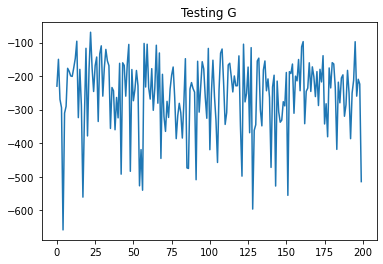

In [62]:
plt.plot(np.arange(TEST_EPISODES), test_G)
plt.title('Testing G')
plt.show()

# Conclusion

After trying all the combinations, interestingly, our team learned that the model <span style='color:red'>**without baseline**</span>, having <span style='color:red'>**step decay function**</span> for $\alpha$-reducing scheme learns the fastest and also has the lowest variance in testing set. For the model with baseline function, we tried both linear and quadratic functions, but both scenarios did not increase the model's learning rate at all. It is worth mentioning that our team members were also spending lots of time exploring PyTorch to see if we can have better performances from the package, but unfortunately without any luck. 

The $\theta$ for the best model that we mentioned is as below.

In [63]:
print(theta)

[0.65037424 0.50545337 0.87860147 0.46456609 0.85223307 0.75013629
 0.66610167 0.98789545 0.25696842 0.         0.63571912 0.84731239
 0.73617463 0.90900139 0.11160313 0.29772374 0.68697019 0.86162606
 0.19863436 0.65718903 0.69965563 0.35239247 0.78996055 0.81404794
 0.19742128 0.94945529 0.47660039 0.66660035 0.21131204 0.80752632
 0.31968612 0.29393597 0.30191818 0.8278894  0.55253369 0.1916774
 0.71425674 0.63987036 0.53320383 0.57252791 0.         0.69523798
 0.53465921 0.07913472 0.         0.27785304 0.99738528 0.22560064
 0.10501535 0.01630078 0.34162745 0.80819806 0.21731962 0.93460497
 0.98849788 0.         0.78490275 0.68536362 0.51564399 0.26911317
 0.66478147 0.77712445 0.47566571 0.98778624 0.49624539 0.67152209
 0.43025928 0.26097774 0.94419636 0.6871313  0.6596554  0.03536889
 0.90619876 0.41874532 0.4759435  0.13563372 0.36224286 0.32616368
 0.14801784 0.7958857  0.52324211 0.89417431 0.79441573 0.62935313
 0.06712699 0.78727001 0.37892603 0.47062239 0.07910067 0.15341